# Organize the annotation in a common file.

## Importing necessary Libraries.

In [102]:
# Necessary libraries.
from numpy import intersect1d, nan
import pandas as pd
import os
from os.path import join, exists
import re
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Helper Functions.

In [103]:
def get_file(filename):
    '''
    Gets the file in list format given the filename.

    Parameters:
        filename -- Path of the file.
        
    Returns:
        list. Contents of WebAnno TSV v3 exported file. Separated by \n.
    '''
    with open(filename, encoding = 'utf-8') as ff:
        text = ff.readlines()
        ff.close()
        return text

def replace_BIO(asp: str, start: bool = True) -> str:
    '''
    If you pass in an aspect category in the form <aspect_category>[anynumber],
    this function will strip the square brakets and 'anynumber'.
    Then, it will add the prefix 'B-' (if it is the beginning of the tag) or
    'I-' (if it lies inside the tag).  
    
    Parameters:
        asp -- str, aspect category in the form <aspect_category>[anynumber].
        start -- Bool, Represents whether the tag is a 'begin' tag.
        
    Returns:
        str. Aspect category in BIO format.
    '''
    
    pattern = r'[\[0-9\]]+'
    asp_bio = re.sub(pattern, '', asp)
    if start:
        asp_bio = 'B-' + asp_bio
    else:
        asp_bio = 'I-' + asp_bio
        
    return asp_bio


def convert_to_bio(highlight: list) -> list:
    '''
    Mapping of keywords and aspects of WebAnno TSVv3 to BIO format.
    
    Parameters:
        highlight -- List of all the highlights in the form <highlight>[anynumber].
        
    Returns:
        List. highlights in BIO format.
    '''
    
    result = ['_']*len(highlight)
    
    for ii, (prev, curr) in enumerate(zip([None]+highlight[:-1], highlight)):
        if curr == '_':
            continue
        else:
            if prev == '_':
                begin = replace_BIO(curr, start = True)
                result[ii] = begin
                
            elif prev != curr and prev != '_':
                begin = replace_BIO(curr, start = True)
                result[ii] = begin
            
            elif prev == curr and prev != '_':
                inside = replace_BIO(curr, start = False)
                result[ii] = inside
                
    return result

def parse_file(filename: str) -> pd.DataFrame:
    """
    Parses a WebAnno TSV v3 file to a DataFrame.
    Preprocessing involved:
        - Converts the aspect category annotations to BIO format.
        - Removes the sentence numbers associated with the annotations in square brackets. e.g. 1[8] --> 1.
        - Removes escape characters like "\".

    Args:
        filename (str): Path to the TSV file.

    Returns:
        pd.DataFrame: DataFrame with columns -- ['s_no, str_id, token, ac, ap, conf, ipv']
    """
    # Getting the exported TSV file.
    text = get_file(filename)
    text = [tt for tt in text if tt != '\n']
    text = text[3:]
    #print(text[:6])

    # Save.
    storage = []
    count = 0    # Sentence counter.
    for ii, line in enumerate(text, 1):
        if line.startswith('#Text'):
            count += 1
            continue
        else:
            splits = line.split()
            if len(splits) == 5:
                splits = splits[:3] + ["_", "_"] + splits[3:]
            storage.append(splits)
   
    # Define DataFrame.
    df = pd.DataFrame(storage, columns = 's_no, str_id, token, ac, ap, conf, ipv'.split(", "))

    # Convert to BIO format.
    df['ac'] = convert_to_bio(df['ac'].to_list())

    # Replace "\\_" with "_" in ac.
    df['ac'] = df['ac'].apply(lambda x: x.replace('\\_', '_'))
    df['ac'] = df['ac'].apply(lambda x: '_' if (x =='B-*') or (x == 'I-*') else x)
    # Fixing aspect polarity.
    df['ap'] = df['ap'].apply(lambda x: x[0] if x != '_' else x)
    df['ap'] = df['ap'].apply(lambda x: '_' if x == '*' else x)

    return df

def merge_annotations(filename_list: list) -> pd.DataFrame:
    """
    Merges the dataframes generated from parse_file function.

    Args:
        filename_list (list): List of filepaths to be parsed.

    Returns:
        pd.DataFrame: DataFrame contaning all the annotations from the files provided.
    """    
    storage = []

    for file in filename_list:
        try:
            parsed = parse_file(file)
            storage.append(parsed)
        except TypeError:
            print(f'Type Error Found in File : {file}')

    res = pd.concat(storage, axis = 0).reset_index(drop = True)
    return res


# For IPV.

## Source directory.

In [104]:
ipv_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\ipv'
common_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\common_annotation\Exported'

## Read files from directory.

In [105]:
shr_common_root = join(common_root, 'shr')
krn_common_root = join(common_root, 'krn')
shr_root_ipv = join(ipv_root, 'Sharmila')
krn_root_ipv = join(ipv_root, 'kiran')

shr_common_ipv = [file for file in os.listdir(shr_common_root) if file.split("_")[1] == "ipv"]
krn_common_ipv = [file for file in os.listdir(krn_common_root) if file.split("_")[1] == "ipv"]
shr_ipv = [file for file in os.listdir(shr_root_ipv) if file not in shr_common_ipv]
krn_ipv = [file for file in os.listdir(krn_root_ipv) if file not in krn_common_ipv]

print(f'Number of annotation files only by shr: {len(shr_ipv)}')
print(f'Number of annotation files only by krn: {len(krn_ipv)}')
print(f'Number of common annotation files by shr: {len(shr_common_ipv)}')
print(f'Number of common annotation files by krn: {len(krn_common_ipv)}')

shr_filenames_ipv = [join(shr_root_ipv, file) for file in shr_ipv]
shr_common_filenames_ipv = [join(shr_common_root, file) for file in shr_common_ipv]
krn_filenames_ipv = [join(krn_root_ipv, file) for file in krn_ipv]
krn_common_filenames_ipv = [join(krn_common_root, file) for file in krn_common_ipv]

print(f"\nNumber of files in Shr: {len(shr_filenames_ipv) + len(shr_common_filenames_ipv)}")
print(f"Number of files in Krn: {len(krn_filenames_ipv) + len(krn_common_filenames_ipv)}")

Number of annotation files only by shr: 113
Number of annotation files only by krn: 69
Number of common annotation files by shr: 35
Number of common annotation files by krn: 0

Number of files in Shr: 148
Number of files in Krn: 69


## Merge to DataFrame.

In [106]:
df_shr_ipv = merge_annotations(shr_filenames_ipv)
df_shr_ipv = pd.concat([pd.DataFrame({"annotator" : ["shr"] * len(df_shr_ipv) }), df_shr_ipv], axis = 1)

df_shr_common_ipv = merge_annotations(shr_common_filenames_ipv)
df_shr_common_ipv = pd.concat([pd.DataFrame({"annotator" : ["shr_common"] * len(df_shr_common_ipv) }), df_shr_common_ipv], axis = 1)

df_krn_ipv = merge_annotations(krn_filenames_ipv)
df_krn_ipv = pd.concat([pd.DataFrame({"annotator" : ["krn"] * len(df_krn_ipv) }), df_krn_ipv], axis = 1)

#df_krn_common_ipv = merge_annotations(krn_common_filenames_ipv)
#df_krn_common_ipv = pd.concat([pd.DataFrame({"annotator" : ["krn_common"] * len(df_krn_common_ipv) }), df_krn_common_ipv], axis = 1)


## Concat all.

In [107]:
#df_ipv = pd.concat([df_shr_ipv, df_shr_common_ipv, df_krn_ipv, df_krn_common_ipv])
df_ipv = pd.concat([df_shr_ipv, df_shr_common_ipv, df_krn_ipv], axis = 0, ignore_index = True)
df_ipv.iloc[500:550, :]

,annotator,s_no,str_id,token,ac,ap,conf,ipv
500,shr,3-3,213-222,चरित्रहीन,B-character_assasination,0,_,_
501,shr,3-4,223-227,केटि,I-character_assasination,0,_,_
502,shr,3-5,228-230,यो,_,_,_,_
503,shr,3-6,231-238,संसारमै,_,_,_,_
504,shr,3-7,239-243,कोहि,_,_,_,_
505,shr,3-8,244-249,छैनन्,_,_,_,_
506,shr,3-9,250-254,होला,_,_,_,_
507,shr,3-10,255-256,?,_,_,8,1
508,shr,4-1,257-259,तँ,_,_,_,_
509,shr,4-2,260-269,दुनियासंग,_,_,_,_


## Basic pre-processing.

In [108]:
def clean_merged(df):
    """
    Cleaner Function.
    """
    
    ### Clean the IPV and conf column.
    df['ipv'] = df['ipv'].apply(lambda x: x[0] if x != "*" else "_")
    df['conf'] = df['conf'].apply(lambda x: x[0] if x != "*" else "_")
    
    ### Clean the aspect category column.
    df['ac'] = df['ac'].replace({"_" : "O"})

    ### Remove bad symbols.
    df['token'] = df['token'].replace({'"' : nan})
    df.dropna(inplace = True)

    return df

In [109]:
df_ipv = clean_merged(df_ipv)

### Add sentence markers.

In [110]:
def add_sentence_marker(df):
    coll = []
    ii = 1
    for item in df['ipv']:
        if item != "_":
            coll.append(coll[-1])
            ii += 1
        else:
            coll.append(f"sentence_{ii}")

    df['sentence_num'] = coll
    df.drop(['s_no', 'str_id'], axis = 1, inplace = True)
    return df

In [111]:
df_ipv = add_sentence_marker(df_ipv)
df_ipv.head(20)

,annotator,token,ac,ap,conf,ipv,sentence_num
0,shr,﻿तेरो,O,_,_,_,sentence_1
1,shr,अश्लिल,B-general_threat,0,_,_,sentence_1
2,shr,फोटोहरू,I-general_threat,0,_,_,sentence_1
3,shr,म,O,_,_,_,sentence_1
4,shr,सार्वजनिक,B-general_threat,0,_,_,sentence_1
5,shr,गरिदिन्छु,O,_,_,_,sentence_1
6,shr,।,O,_,6,1,sentence_1
7,shr,उसको,O,_,_,_,sentence_2
8,shr,नग्न,B-general_threat,0,_,_,sentence_2
9,shr,फोटोहरु,I-general_threat,0,_,_,sentence_2


In [112]:
df_ipv.ap.unique()

array(['_', '0', '1'], dtype=object)

## Group data by sentence numbers.

In [113]:
# Group by sentence numbers.
grouped = df_ipv.groupby("sentence_num")

tokens = grouped.apply(lambda df: [w for w in df['token'].values.tolist()]).to_list()
ac = grouped.apply(lambda df: [w for w in df['ac'].values.tolist()]).to_list()
ap = grouped.apply(lambda df: [w for w in df['ap'].values.tolist()]).to_list()

annot = grouped.apply(lambda df: [w for w in df['annotator'].values.tolist()][0]).to_list()

conf = grouped.apply(lambda df: [w for w in df['conf'].values.tolist()]).to_list()
conf = [item[-1] for item in conf]

is_ipv = grouped.apply(lambda df: [w for w in df['ipv'].values.tolist()]).to_list()
is_ipv = list(map(int, [item[-1] for item in is_ipv]))


In [ ]:
len(ac), len(ap), len(tokens), len(is_ipv), len(conf), len(annot)

(2374, 2374, 2374, 2374, 2374, 2374)

## Create new DataFrame for IPV examples.

In [ ]:
new_df_ipv = pd.DataFrame({
    'id': range(1, len(is_ipv) + 1),
    'source': 'simulation_ipv',
    'annotator': annot,
    'text': [" ".join(word_list) for word_list in tokens],
    'tokens': tokens,
    'ac': ac,
    'ap': ap,
    'conf': conf,
    'ipv': is_ipv
})

In [ ]:
new_df_ipv.head(30)

,id,source,annotator,text,tokens,ac,ap,conf,ipv
0,1,simulation_ipv,shr,﻿तेरो अश्लिल फोटोहरू म सार्वजनिक गरिदिन्छु ।,"[﻿तेरो, अश्लिल, फोटोहरू, म, सार्वजनिक, गरिदिन्छु, ।]","[O, B-general_threat, I-general_threat, O, B-general_threat, O, O]","[_, 0, 0, _, 0, _, _]",6,1
1,2,simulation_ipv,shr,सम्पत्तिकै लागि बिहे गरेकी रैछ त्यसले ।,"[सम्पत्तिकै, लागि, बिहे, गरेकी, रैछ, त्यसले, ।]","[B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1
2,3,simulation_ipv,shr,हेर्दै जा रन्डी म तेरो लाइफ कसरी बिगार्दिन्छु |,"[हेर्दै, जा, रन्डी, म, तेरो, लाइफ, कसरी, बिगार्दिन्छु, |]","[O, O, B-profanity, B-general_threat, I-general_threat, I-general_threat, I-general_threat, I-general_threat, O]","[_, _, 0, 1, 1, 1, 1, 1, _]",8,1
3,4,simulation_ipv,shr,अलिकति लाज छैन है तलाई त दुनियासंग रात बिताउनि इज्जत नभएकी केटि |,"[अलिकति, लाज, छैन, है, तलाई, त, दुनियासंग, रात, बिताउनि, इज्जत, नभएकी, केटि, |]","[O, B-profanity, I-profanity, O, O, O, B-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, O]","[_, 0, 0, _, _, _, 1, 1, 1, 1, 1, 1, _]",6,1
4,5,simulation_ipv,shr,"गोहीको आसु नझार कुकुर्नी , आफ्नो गल्ति लुकाउन छोरि मान्छेले आसु पहिले देखाउने गर्छन मलाई थाहा छ |","[गोहीको, आसु, नझार, कुकुर्नी, ,, आफ्नो, गल्ति, लुकाउन, छोरि, मान्छेले, आसु, पहिले, देखाउने, गर्छन, मलाई, थाहा, छ, |]","[B-profanity, I-profanity, I-profanity, I-profanity, O, O, B-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, O, O, O, O]","[0, 0, 0, 0, _, _, 0, 0, 0, 0, 0, 0, 0, 0, _, _, _, _]",6,1
5,6,simulation_ipv,shr,भालुनी आफुले इज्जत पाउनको लागि अरुको पनि इज्जत गर्न सिक |,"[भालुनी, आफुले, इज्जत, पाउनको, लागि, अरुको, पनि, इज्जत, गर्न, सिक, |]","[B-profanity, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, O]","[0, _, _, _, _, _, _, 0, 0, 0, _]",6,1
6,7,simulation_ipv,shr,झुन्डिएर मर्नु नि के अनुहार देखाउदै हिड्छेस् भालु |,"[झुन्डिएर, मर्नु, नि, के, अनुहार, देखाउदै, हिड्छेस्, भालु, |]","[B-profanity, I-profanity, I-profanity, O, O, O, O, B-profanity, O]","[1, 1, 1, _, _, _, _, 0, _]",5,1
7,8,simulation_ipv,shr,"बौलाई तेरो र मेरो औकात मिल्नु पर्यो हौ , कहाँ म कहाँ तँ झुटि |","[बौलाई, तेरो, र, मेरो, औकात, मिल्नु, पर्यो, हौ, ,, कहाँ, म, कहाँ, तँ, झुटि, |]","[B-profanity, O, O, O, B-profanity, I-profanity, I-profanity, I-profanity, O, O, O, O, O, B-profanity, O]","[0, _, _, _, 1, 1, 1, 1, _, _, _, _, _, 0, _]",8,1
8,9,simulation_ipv,shr,ओइ कुकुर्नी मेरो बेज्जत गरेर के पाहिस भन् त !,"[ओइ, कुकुर्नी, मेरो, बेज्जत, गरेर, के, पाहिस, भन्, त, !]","[O, B-profanity, O, O, O, O, O, O, O, O]","[_, 0, _, _, _, _, _, _, _, _]",6,1
9,10,simulation_ipv,shr,"बादरनी , कुकुर्नी धोका दिन्छेस् मलाई |","[बादरनी, ,, कुकुर्नी, धोका, दिन्छेस्, मलाई, |]","[B-profanity, I-profanity, I-profanity, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1


# For non-IPV.

In [ ]:
non_ipv_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\non-ipv'
common_root = r'D:\ML_projects\IPV-Project\annotation\data\first_lot\common_annotation\Exported'

## Read files from directory.
shr_common_root = join(common_root, 'shr')
krn_common_root = join(common_root, 'krn')
shr_root_non_ipv = join(non_ipv_root, 'shr')
krn_root_non_ipv = join(non_ipv_root, 'krn')

shr_common_non_ipv = [file for file in os.listdir(shr_common_root) if file.split("_")[1] == "non"]
krn_common_non_ipv = [file for file in os.listdir(krn_common_root) if file.split("_")[1] == "non"]
shr_non_ipv = [file for file in os.listdir(shr_root_non_ipv) if file not in shr_common_non_ipv]
krn_non_ipv = [file for file in os.listdir(krn_root_non_ipv) if file not in krn_common_non_ipv]

print(f'Number of annotation files only by shr: {len(shr_non_ipv)}')
print(f'Number of annotation files only by krn: {len(krn_non_ipv)}')
print(f'Number of common annotation files by shr: {len(shr_common_non_ipv)}')
print(f'Number of common annotation files by krn: {len(krn_common_non_ipv)}')

shr_filenames_non_ipv = [join(shr_root_non_ipv, file) for file in shr_non_ipv]
shr_common_filenames_non_ipv = [join(shr_common_root, file) for file in shr_common_non_ipv]
krn_filenames_non_ipv = [join(krn_root_non_ipv, file) for file in krn_non_ipv]
krn_common_filenames_non_ipv = [join(krn_common_root, file) for file in krn_common_non_ipv]

print(f"\nNumber of files in Shr: {len(shr_filenames_non_ipv) + len(shr_common_filenames_non_ipv)}")
print(f"Number of files in Krn: {len(krn_filenames_non_ipv) + len(krn_common_filenames_non_ipv)}")


Number of annotation files only by shr: 84
Number of annotation files only by krn: 78
Number of common annotation files by shr: 20
Number of common annotation files by krn: 0

Number of files in Shr: 104
Number of files in Krn: 78


In [ ]:
## Merge to DataFrame.
df_shr_non_ipv = merge_annotations(shr_filenames_non_ipv)
df_shr_non_ipv = pd.concat([pd.DataFrame({"annotator" : ["shr"] * len(df_shr_non_ipv) }), df_shr_non_ipv], axis = 1)

df_shr_common_non_ipv = merge_annotations(shr_common_filenames_non_ipv)
df_shr_common_non_ipv = pd.concat([pd.DataFrame({"annotator" : ["shr_common"] * len(df_shr_common_non_ipv) }), df_shr_common_non_ipv], axis = 1)

df_krn_non_ipv = merge_annotations(krn_filenames_non_ipv)
df_krn_non_ipv = pd.concat([pd.DataFrame({"annotator" : ["krn"] * len(df_krn_non_ipv) }), df_krn_non_ipv], axis = 1)

#df_krn_common_non_ipv = merge_annotations(krn_common_filenames_non_ipv)
#df_krn_common_non_ipv = pd.concat([pd.DataFrame({"annotator" : ["krn_common"] * len(df_krn_common_non_ipv) }), df_krn_common_non_ipv], axis = 1)

## Concat all.
#df_non_ipv = pd.concat([df_shr_non_ipv, df_shr_common_non_ipv, df_krn_non_ipv, df_krn_common_non_ipv])
df_non_ipv = pd.concat([df_shr_non_ipv, df_shr_common_non_ipv, df_krn_non_ipv], axis = 0, ignore_index = True)
df_non_ipv.iloc[500:550, :]


,annotator,s_no,str_id,token,ac,ap,conf,ipv
500,shr,1-7,32-35,लाई,_,_,_,_
501,shr,1-8,36-42,पशुपति,_,_,_,_
502,shr,1-9,43-45,मा,_,_,_,_
503,shr,1-10,46-50,लगेर,_,_,_,_
504,shr,1-11,51-57,जलाउनु,_,_,_,_
505,shr,1-12,58-62,पर्छ,_,_,_,_
506,shr,1-13,63-65,यी,_,_,_,_
507,shr,1-14,66-70,साले,B-profanity,0,_,_
508,shr,1-15,71-76,पताकि,I-profanity,0,_,_
509,shr,1-16,77-80,हरु,_,_,_,_


In [ ]:
## Basic pre-processing.
df_non_ipv = clean_merged(df_non_ipv)

### Add sentence markers.
df_non_ipv = add_sentence_marker(df_non_ipv)



In [ ]:
df_non_ipv.head()

,annotator,token,ac,ap,conf,ipv,sentence_num
0,shr,तिमी,O,_,_,_,sentence_1
1,shr,कति,O,_,_,_,sentence_1
2,shr,राम्री,O,_,_,_,sentence_1
3,shr,छौ,O,_,_,_,sentence_1
4,shr,|,O,_,9,0,sentence_1


In [ ]:
## Group data by sentence numbers.
# Group by sentence numbers.
grouped = df_non_ipv.groupby("sentence_num")

tokens = grouped.apply(lambda df: [w for w in df['token'].values.tolist()]).to_list()
ac = grouped.apply(lambda df: [w for w in df['ac'].values.tolist()]).to_list()
ap = grouped.apply(lambda df: [w for w in df['ap'].values.tolist()]).to_list()

annot = grouped.apply(lambda df: [w for w in df['annotator'].values.tolist()][0]).to_list()

conf = grouped.apply(lambda df: [w for w in df['conf'].values.tolist()]).to_list()
conf = [item[-1] for item in conf]

is_non_ipv = grouped.apply(lambda df: [w for w in df['ipv'].values.tolist()]).to_list()
is_non_ipv = list(map(int, [item[-1] for item in is_non_ipv]))

len(ac), len(ap), len(tokens), len(is_non_ipv), len(conf), len(annot)


(1986, 1986, 1986, 1986, 1986, 1986)

In [ ]:
## Create new DataFrame for IPV examples.
new_df_non_ipv = pd.DataFrame({
    'id': range(1, len(is_non_ipv) + 1),
    'source': 'simulation_non_ipv',
    'annotator': annot,
    'text': [" ".join(word_list) for word_list in tokens],
    'tokens': tokens,
    'ac': ac,
    'ap': ap,
    'conf': conf,
    'ipv': is_non_ipv
})

## Add text field in the final df.
def strip_extra_punctuation(ll: list):
    from string import punctuation
    if ll[-2][-1] in set(punctuation + "।"):
        ll[-2] = ll[-2][:-1]
    return ll

new_df_non_ipv['text'] = new_df_non_ipv['text'].apply(strip_extra_punctuation)
new_df_non_ipv.head(30)

,id,source,annotator,text,tokens,ac,ap,conf,non_ipv
0,1,simulation_non_ipv,shr,तिमी कति राम्री छौ |,"[तिमी, कति, राम्री, छौ, |]","[O, O, O, O, O]","[_, _, _, _, _]",9,0
1,2,simulation_non_ipv,shr,सानु तिमी र म भेटम न ल |,"[सानु, तिमी, र, म, भेटम, न, ल, |]","[O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _]",9,0
2,3,simulation_non_ipv,shr,यो पुलिस हासिहासी बोले को छ ए लाई सजाए हुनुपर्छ कुरा लुकाएर का पुग्छ हामी पनि रगत को खोली बगाउन तयार हामी छ्म ।,"[यो, पुलिस, हासिहासी, बोले, को, छ, ए, लाई, सजाए, हुनुपर्छ, कुरा, लुकाएर, का, पुग्छ, हामी, पनि, रगत, को, खोली, बगाउन, तयार, हामी, छ्म, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
3,4,simulation_non_ipv,shr_common,बिध्यादेबि साले रण्डि को छोरी पोईमारा पसुपति ले तेरो छिटै अन्त्य गरून् अरु को इज्जत गर्न आउदैन रैच ।,"[बिध्यादेबि, साले, रण्डि, को, छोरी, पोईमारा, पसुपति, ले, तेरो, छिटै, अन्त्य, गरून्, अरु, को, इज्जत, गर्न, आउदैन, रैच, ।]","[O, B-profanity, I-profanity, I-profanity, I-profanity, I-profanity, B-general_threat, I-general_threat, I-general_threat, I-general_threat, I-general_threat, I-general_threat, O, O, O, O, O, O, O]","[_, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, _, _, _, _, _, _, _]",1,0
4,5,simulation_non_ipv,shr_common,शेरे बोल्छनै तेस्तै पत नपाउदा मुर्छा परेछ साला चोर हुनत म बिध्या भन्दारि लाई हाई हाई भन्न खोजे को होइन है साथी हो ।,"[शेरे, बोल्छनै, तेस्तै, पत, नपाउदा, मुर्छा, परेछ, साला, चोर, हुनत, म, बिध्या, भन्दारि, लाई, हाई, हाई, भन्न, खोजे, को, होइन, है, साथी, हो, ।]","[O, O, O, O, O, O, O, B-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, 0, 0, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
5,6,simulation_non_ipv,shr_common,याे मदनेकि स्वास्नी हाे कि केपिकि रखेल ?,"[याे, मदनेकि, स्वास्नी, हाे, कि, केपिकि, रखेल, ?]","[O, B-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, O]","[_, 1, 1, 1, 1, 1, 1, _]",1,0
6,7,simulation_non_ipv,shr_common,पुन्य गौतम ग्यानेन्द्र साहि को घटना मा नेकपा लाई आरोप लागे को भय रण्डि को बान किन तेरो पुलिस ले समाउदैन ।,"[पुन्य, गौतम, ग्यानेन्द्र, साहि, को, घटना, मा, नेकपा, लाई, आरोप, लागे, को, भय, रण्डि, को, बान, किन, तेरो, पुलिस, ले, समाउदैन, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, 0, 0, 0, _, _, _, _, _, _]",1,0
7,8,simulation_non_ipv,shr_common,यो पुण्य गौतम सरकार को नोकर नभए पनि नेकपा को अवश्य बफादार कुक्कुर हो ।,"[यो, पुण्य, गौतम, सरकार, को, नोकर, नभए, पनि, नेकपा, को, अवश्य, बफादार, कुक्कुर, हो, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, B-profanity, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, 0, _, _]",1,0
8,9,simulation_non_ipv,shr_common,देस र जन्ता को सेवा गर्छु भन्न लाज लाग्दैन रन्डि को छोरा पुन्री गौतम ।,"[देस, र, जन्ता, को, सेवा, गर्छु, भन्न, लाज, लाग्दैन, रन्डि, को, छोरा, पुन्री, गौतम, ।]","[O, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, I-profanity, I-profanity, O, O, O]","[_, _, _, _, _, _, _, 0, 0, 0, 0, 0, _, _, _]",1,0
9,10,simulation_non_ipv,shr_common,यो साला पून्य कहिले मर्छ होला कुकूर भूके जस्तै भूक्छ ।,"[यो, साला, पून्य, कहिले, मर्छ, होला, कुकूर, भूके, जस्तै, भूक्छ, ।]","[O, B-profanity, O, B-physical_threat, I-physical_threat, I-physical_threat, O, O, O, O, O]","[_, 0, _, 0, 0, 0, _, _, _, _, _]",1,0


# For Twitter data.

## Original.

In [ ]:
twt_root = r'D:\ML_projects\IPV-Scraper\results'
twt_filename = 'scraped_tweets_cleaned_22-04-022.csv'

twt_df = pd.read_csv(join(twt_root, twt_filename), encoding = 'utf-8')
print(f'Shape before: {twt_df.shape}')

# Remove NA and duplicates.
twt_df.dropna(inplace = True)
twt_df.drop_duplicates(inplace = True)

print(f'Shape after: {twt_df.shape}')

## Add ID and Source columns.
twt_df['id'] = range(1, len(twt_df) + 1)
twt_df['source'] = ['twitter'] * len(twt_df)
twt_df = twt_df.rename(columns={'tweet': 'text'})

twt_df.tail()


Shape before: (1418, 4)
Shape after: (1418, 4)


,date,text,link,keyword,id,source
1413,2018-01-23 10:54:25,धेरै ताती सकिस यादगर एकदिन आफै सितल हुन्छेस सुन बुढो खोज्दै हिड्छेस एकदिन आफै पितल हुन्छेस,https://twitter.com/tOr7AvpntQeXeQP/status/955668770609037313,हिड्छेस,1414,Twitter
1414,2018-01-19 22:30:41,त पोके त होस रौसी खादै हिड्छेस,https://twitter.com/omkarpdl/status/954394440889593857,हिड्छेस,1415,Twitter
1415,2017-12-26 20:34:45,घरमा माया गर्ने आफ्ना आमा बाबू हुदा हुँदै अर्काको छोरालाइ माया गर्दै हिड्छेस त धोका नपाए के iphone पाउछेस त।,https://twitter.com/ayush_kan/status/945667956863676416,हिड्छेस,1416,Twitter
1416,2017-12-22 19:29:59,"अध्यारोमा हिडिरहदा-छाया लाई सोध्न मन लाग्छ। ओई त म संग किन हिड्छेस यस्ले नि सजिलै उत्तर देला, तँ संग हिड्ने अरु को नै छ र!",https://twitter.com/UjyaaloPradip/status/944202108181520385,हिड्छेस,1417,Twitter
1417,2017-10-12 00:30:05,मेरो बुढासंग सुतेर हिड्छेस भन्दै दुइ महिला बाटो बाटो झगडा गरे पछी भिडीयो सहित.,https://twitter.com/sajhapage/status/918185701757280256,हिड्छेस,1418,Twitter


## Annotated.

In [ ]:
twitter_root = r'D:\ML_projects\IPV-Project\annotation\data\second_lot\exported_twitter'
shr_twt_root = join(twitter_root, 'shr')
krn_twt_root = join(twitter_root, 'krn')

shr_twt = os.listdir(shr_twt_root)
krn_twt = os.listdir(krn_twt_root)

print(f'Number of annotation files only by shr: {len(shr_twt)}')
print(f'Number of annotation files only by krn: {len(krn_twt)}')

shr_filenames_twt = [join(shr_twt_root, file) for file in shr_twt]
krn_filenames_twt = [join(krn_twt_root, file) for file in krn_twt]

Number of annotation files only by shr: 71
Number of annotation files only by krn: 71


In [ ]:
## Merge to DataFrame.
df_shr_twt = merge_annotations(shr_filenames_twt)
df_shr_twt = pd.concat([pd.DataFrame({"annotator" : ["shr"] * len(df_shr_twt) }), df_shr_twt], axis = 1)

df_krn_twt = merge_annotations(krn_filenames_twt)
df_krn_twt = pd.concat([pd.DataFrame({"annotator" : ["krn"] * len(df_krn_twt) }), df_krn_twt], axis = 1)

df_twt = pd.concat([df_shr_twt, df_krn_twt], axis = 0, ignore_index = True)


Type Error Found in File : D:\ML_projects\IPV-Project\annotation\data\second_lot\exported_twitter\shr\batch_twitter_1170-1180.tsv


In [ ]:
## Drop Na values in "ipv" column.
df_twt.dropna(inplace = True)

## Basic pre-processing.
df_twt = clean_merged(df_twt)

### Add sentence markers.
df_twt = add_sentence_marker(df_twt)


In [ ]:
## Group data by sentence numbers.
# Group by sentence numbers.
grouped = df_twt.groupby("sentence_num")

tokens = grouped.apply(lambda df: [w for w in df['token'].values.tolist()]).to_list()
ac = grouped.apply(lambda df: [w for w in df['ac'].values.tolist()]).to_list()
ap = grouped.apply(lambda df: [w for w in df['ap'].values.tolist()]).to_list()

annot = grouped.apply(lambda df: [w for w in df['annotator'].values.tolist()][0]).to_list()

conf = grouped.apply(lambda df: [w for w in df['conf'].values.tolist()]).to_list()
conf = [item[-1] for item in conf]

is_twt = grouped.apply(lambda df: [w for w in df['ipv'].values.tolist()]).to_list()
is_twt = list(map(int, [item[-1] for item in is_twt]))

len(ac), len(ap), len(tokens), len(is_twt), len(conf), len(annot)


(1397, 1397, 1397, 1397, 1397, 1397)

In [ ]:

## Create new DataFrame for IPV examples.
new_df_twt = pd.DataFrame({
    'id': range(1, len(is_twt) + 1),
    'source': 'twitter',
    'annotator': annot,
    'text': [" ".join(word_list) for word_list in tokens],
    'tokens': tokens,
    'ac': ac,
    'ap': ap,
    'conf': conf,
    'ipv': is_twt
})

## Add text field in the final df.
def strip_extra_punctuation(ll: list):
    from string import punctuation
    if ll[-2][-1] in set(punctuation + "।"):
        ll[-2] = ll[-2][:-1]
    return ll

new_df_twt['text'] = new_df_twt['text'].apply(strip_extra_punctuation)
new_df_twt.head(30)

,id,source,annotator,text,tokens,ac,ap,conf,twt
0,1,twitter,shr,"सब काल्पनिक चरित्र | यता ओली ट्यान्की , ८ आना , भ्रश्टाचारी , यती समूहको सिमित घेरामा , उता गठबन्धन हत्यारा , बलात्कारी , भ्रश्टाचारी , लुटाहाको ब्रिहत घेरामा । दुबैमा खासै अन्तर छैन घेरा सांघुरो र ब्रिहत मात्रै हो |","[सब, काल्पनिक, चरित्र, |, यता, ओली, ट्यान्की, ,, ८, आना, ,, भ्रश्टाचारी, ,, यती, समूहको, सिमित, घेरामा, ,, उता, गठबन्धन, हत्यारा, ,, बलात्कारी, ,, भ्रश्टाचारी, ,, लुटाहाको, ब्रिहत, घेरामा, ।, दुबैमा, खासै, अन्तर, छैन, घेरा, सांघुरो, र, ब्रिहत, मात्रै, हो, |]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
1,2,twitter,shr,जस्ले आफ्नो नाम पनि ईमान्दारीताका साथ भन्न सक्दैन् त्यस्ले lack of loyal loyaly भन्दै ईमान्दारीताको पाठ नपढाए हुन्छ अनि जो केटी देख्नासाथ वैंस चढेको कुकुर जसरी पुच्छर हल्लाउदै उफ्रिन्छ तिनले पनि मुखमा लगाए हुन्छ |,"[जस्ले, आफ्नो, नाम, पनि, ईमान्दारीताका, साथ, भन्न, सक्दैन्, त्यस्ले, lack, of, loyal, loyaly, भन्दै, ईमान्दारीताको, पाठ, नपढाए, हुन्छ, अनि, जो, केटी, देख्नासाथ, वैंस, चढेको, कुकुर, जसरी, पुच्छर, हल्लाउदै, उफ्रिन्छ, तिनले, पनि, मुखमा, लगाए, हुन्छ, |]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, I-profanity, I-profanity, I-profanity, I-profanity, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, 0, 0, 0, 0, 0, 0, 0, _, _, _, _, _, _]",1,0
2,3,twitter,shr,"जस्तोसुकै नाफामूलक संस्था भनिएता पनि मुनाफा लिने हकमा त्यो संस्था निश्चित संहिता र व्यवस्थाभन्दा पर जान सक्दैन । शैक्षिक संस्थाहरूले मुनाफाको लोभमा आफ्नो व्यावसायिक चरित्र भुलेर जुत्ता , मोजा , कपडा , झोलादेखि किताब तथा शैक्षिक सामग्रीहरूसम्मको व्यापार गर्न मिल्ने जस्तो त लाग्दैन ।","[जस्तोसुकै, नाफामूलक, संस्था, भनिएता, पनि, मुनाफा, लिने, हकमा, त्यो, संस्था, निश्चित, संहिता, र, व्यवस्थाभन्दा, पर, जान, सक्दैन, ।, शैक्षिक, संस्थाहरूले, मुनाफाको, लोभमा, आफ्नो, व्यावसायिक, चरित्र, भुलेर, जुत्ता, ,, मोजा, ,, कपडा, ,, झोलादेखि, किताब, तथा, शैक्षिक, सामग्रीहरूसम्मको, व्यापार, गर्न, मिल्ने, जस्तो, त, लाग्दैन, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
3,4,twitter,krn,कन्याजाली फुटिहालेको छैन । लाज पचेकी गायिका - २०७९ |,"[कन्याजाली, फुटिहालेको, छैन, ।, लाज, पचेकी, गायिका, -, २०७९, |]","[O, O, O, O, B-character_assasination, I-character_assasination, I-character_assasination, O, O, O]","[_, _, _, _, 0, 0, 0, _, _, _]",1,0
4,5,twitter,krn,Snapcha बाट कुकुर त बन्यै तर कुकुर जस्तै बफादार कहिले बन्छेऊ नानी |,"[Snapcha, बाट, कुकुर, त, बन्यै, तर, कुकुर, जस्तै, बफादार, कहिले, बन्छेऊ, नानी, |]","[O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, O, O, O, O]","[_, _, _, _, _, _, 0, 0, 0, _, _, _, _]",1,0
5,6,twitter,krn,"ए , हो र ? लिन पठाईदिम त ? फेरि कुकुर छन कि घरमा ?","[ए, ,, हो, र, ?, लिन, पठाईदिम, त, ?, फेरि, कुकुर, छन, कि, घरमा, ?]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
6,7,twitter,krn,कसैको घर भाँड्नु परेमा वहाँ लाई सम्पार्क गर्नु होला वहाँ भाँड्ने मात्र भन्दा पनि फँडानी हानी दिनुहुन्छ रे । अब सेवा सर्त बारेमा बुझ्न चाहिं वहाँ लाई नै सम्पार्क गर्नुहोला |,"[कसैको, घर, भाँड्नु, परेमा, वहाँ, लाई, सम्पार्क, गर्नु, होला, वहाँ, भाँड्ने, मात्र, भन्दा, पनि, फँडानी, हानी, दिनुहुन्छ, रे, ।, अब, सेवा, सर्त, बारेमा, बुझ्न, चाहिं, वहाँ, लाई, नै, सम्पार्क, गर्नुहोला, |]","[O, B-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, 0, 0, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0
7,8,twitter,krn,कठै मेरो समाज जहाँ बलात्कारी शिर उठाएर हिड्छ अनि बलात्कार भएको पिडित महिला आफ्नो इज्जत गयो भन्दै 

In [ ]:
def is_same(l1, l2):
    n_common = 2
    if l1[:n_common] == l2[:n_common]:
        return True
    else:
        return False

In [ ]:
counter = 0
import numpy as np
urls = [np.nan] * len(new_df_twt)
keywords = [np.nan] * len(new_df_twt)
date = [np.nan] * len(new_df_twt)

for jj, t2 in enumerate(new_df_twt.tokens.values):
    match_found = False
    for ii, t1 in enumerate(twt_df.text.str.split()):
        if is_same(t1,t2):
            #print(t1)
            #print(t2)
            urls[jj] = twt_df.link.iloc[ii]
            keywords[jj] = twt_df.keyword.iloc[ii]
            date[jj] = twt_df.date.iloc[ii]
            #print('-'*50)
            counter += 1
            match_found = True
            break

new_df_twt['link'] = urls
new_df_twt['keyword'] = keywords
new_df_twt['date'] = date
new_df_twt.fillna(method = 'ffill', inplace = True)

In [ ]:
new_df_twt.sample(10)

,id,source,annotator,text,tokens,ac,ap,conf,twt,link,keyword,date
594,595,twitter,shr,यस्तो फाल्तु टुइट गरेर मान्छेको दिमाग भाँड्ने घर बिगार्ने काम नगरे पनि हुन्न र। केटीहरु ले तपाइको कुरालाइ सिरेस्ली लिन्छन् |,"[यस्तो, फाल्तु, टुइट, गरेर, मान्छेको, दिमाग, भाँड्ने, घर, बिगार्ने, काम, नगरे, पनि, हुन्न, र।, केटीहरु, ले, तपाइको, कुरालाइ, सिरेस्ली, लिन्छन्, |]","[O, O, O, O, B-profanity, I-profanity, I-profanity, I-profanity, I-profanity, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, 0, 0, 0, 0, 0, _, _, _, _, _, _, _, _, _, _, _, _]",1,0,https://twitter.com/Gtmsuresh/status/741795201136656384,घर भाँड्ने,2016-06-12 06:37:12
858,859,twitter,shr,आडम्बरी - नेपालको आफ्नै गाउ घरमा जातको आधारमा छुवाछुत बारेर छोरी नदिने वा छोरी बिहा नगर्ने तर बिदेशी गोरे-गोरेनी देखे पछी ज्यान फालेर पछी लाग्ने उपल्ला जाती आडम्बरी हुन। दमिनी कमिनीलाई छिछी गर्नेले गोरी केटी भित्र्याउन खोज्दा बाउ आमाले छोराको गालामा पड्याम्म बजाउनु पर्दैन ?,"[आडम्बरी, -, नेपालको, आफ्नै, गाउ, घरमा, जातको, आधारमा, छुवाछुत, बारेर, छोरी, नदिने, वा, छोरी, बिहा, नगर्ने, तर, बिदेशी, गोरे-गोरेनी, देखे, पछी, ज्यान, फालेर, पछी, लाग्ने, उपल्ला, जाती, आडम्बरी, हुन।, दमिनी, कमिनीलाई, छिछी, गर्नेले, गोरी, केटी, भित्र्याउन, खोज्दा, बाउ, आमाले, छोराको, गालामा, पड्याम्म, बजाउनु, पर्दैन, ?]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-physical_threat, I-physical_threat, I-physical_threat, I-physical_threat, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, 0, 0, 0, 0, _]",1,0,https://twitter.com/bandesh/status/1516432111884206080,कुकुर OR कुकुर्नी,2022-04-19 20:47:44
794,795,twitter,shr,"कुनै बेलामा अत्यन्त दुखद घटेको घटना , जसलाई आम जनताले सम्झन पनि चाहदैनन्। त्यस्तै घटना फेरि दोहोर्‍याइ दिन्छु , ज्यानले मार्दिन्छु , त्यो पनि देशको सर्वमान्य मन्त्री जस्तो पदमा बसेर धम्कीपूर्ण तरिकाले खुला मंचबाट बोल्नु एकदमै निन्दनीय , भत्र्सनायोग्य तथा देशको गरिमा बिपरित हो। ।","[कुनै, बेलामा, अत्यन्त, दुखद, घटेको, घटना, ,, जसलाई, आम, जनताले, सम्झन, पनि, चाहदैनन्।, त्यस्तै, घटना, फेरि, दोहोर्‍याइ, दिन्छु, ,, ज्यानले, मार्दिन्छु, ,, त्यो, पनि, देशको, सर्वमान्य, मन्त्री, जस्तो, पदमा, बसेर, धम्कीपूर्ण, तरिकाले, खुला, मंचबाट, बोल्नु, एकदमै, निन्दनीय, ,, भत्र्सनायोग्य, तथा, देशको, गरिमा, बिपरित, हो।, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0,https://twitter.com/JunaidZoonu/status/1484199505943834624,मार्दिन्छु OR मारिदिन्छु,2022-01-20 22:06:51
134,135,twitter,krn,मन मिले सम्म चमत्कार । मन नमिले पछी बलात्कार । |,"[मन, मिले, सम्म, चमत्कार, ।, मन, नमिले, पछी, बलात्कार, ।, |]","[O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _]",1,0,https://twitter.com/YounghangD/status/1517000079982604288,बलात्कारी OR बलत्कार OR बलात्कार,2022-04-21 10:24:38
334,335,twitter,shr,"कस्तो अप्ठ्यारोमा फालिस ए जिन्दगी , सपना र रहरले भर्याङ्ग हाल्छ यथार्थले खुट्टा काटिदिन्छ ।","[कस्तो, अप्ठ्यारोमा, फालिस, ए, जिन्दगी, ,, सपना, र, रहरले, भर्याङ्ग, हाल्छ, यथार्थले, खुट्टा, काटिदिन्छ, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _]",1,0,https://twitter.com/Maunata2870/status/1511155202531147777,फालिस,2022-04-05 07:19:10
781,782,twitter,shr,अचाल घिउ खानु ठुलो हैन खाको देखाउनु ठुलो। राडी भित्रै केमेरा राखेर हेरओ पैलो पल्ट लाइभ मैले राडी ओढेर घिउ खाको छु ~ भन्दा बढि चर्चा र फैदा छ। र त्यै भैरको छ। ।,"[अचाल, घिउ, खानु, ठुलो, हैन, खाको, देखाउनु, ठुलो।, राडी, भित्रै, केमेरा, राखेर, हेरओ, पैलो, पल्ट, लाइभ, मैले, राडी, ओढेर, घिउ, खाको, छु, ~, भन्दा, बढि, चर्चा, र, फैदा, छ।, र, त्यै, भैरको, छ।, ।]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _,

# All data.

In [ ]:
df = pd.concat([new_df_ipv, new_df_non_ipv, new_df_twt], axis = 0, ignore_index = True)

# Reset ID column.
df['id'] = range(1, len(df) + 1)

In [101]:
df.head(40)

,id,source,annotator,text,tokens,ac,ap,conf,ipv,non_ipv,twt,link,keyword,date
0,1,simulation_ipv,shr,﻿तेरो अश्लिल फोटोहरू म सार्वजनिक गरिदिन्छु ।,"[﻿तेरो, अश्लिल, फोटोहरू, म, सार्वजनिक, गरिदिन्छु, ।]","[O, B-general_threat, I-general_threat, O, B-general_threat, O, O]","[_, 0, 0, _, 0, _, _]",6,1.0,NaN,NaN,NaN,NaN,NaN
1,2,simulation_ipv,shr,सम्पत्तिकै लागि बिहे गरेकी रैछ त्यसले ।,"[सम्पत्तिकै, लागि, बिहे, गरेकी, रैछ, त्यसले, ।]","[B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1.0,NaN,NaN,NaN,NaN,NaN
2,3,simulation_ipv,shr,हेर्दै जा रन्डी म तेरो लाइफ कसरी बिगार्दिन्छु |,"[हेर्दै, जा, रन्डी, म, तेरो, लाइफ, कसरी, बिगार्दिन्छु, |]","[O, O, B-profanity, B-general_threat, I-general_threat, I-general_threat, I-general_threat, I-general_threat, O]","[_, _, 0, 1, 1, 1, 1, 1, _]",8,1.0,NaN,NaN,NaN,NaN,NaN
3,4,simulation_ipv,shr,अलिकति लाज छैन है तलाई त दुनियासंग रात बिताउनि इज्जत नभएकी केटि |,"[अलिकति, लाज, छैन, है, तलाई, त, दुनियासंग, रात, बिताउनि, इज्जत, नभएकी, केटि, |]","[O, B-profanity, I-profanity, O, O, O, B-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, I-character_assasination, O]","[_, 0, 0, _, _, _, 1, 1, 1, 1, 1, 1, _]",6,1.0,NaN,NaN,NaN,NaN,NaN
4,5,simulation_ipv,shr,"गोहीको आसु नझार कुकुर्नी , आफ्नो गल्ति लुकाउन छोरि मान्छेले आसु पहिले देखाउने गर्छन मलाई थाहा छ |","[गोहीको, आसु, नझार, कुकुर्नी, ,, आफ्नो, गल्ति, लुकाउन, छोरि, मान्छेले, आसु, पहिले, देखाउने, गर्छन, मलाई, थाहा, छ, |]","[B-profanity, I-profanity, I-profanity, I-profanity, O, O, B-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, I-sexism, O, O, O, O]","[0, 0, 0, 0, _, _, 0, 0, 0, 0, 0, 0, 0, 0, _, _, _, _]",6,1.0,NaN,NaN,NaN,NaN,NaN
5,6,simulation_ipv,shr,भालुनी आफुले इज्जत पाउनको लागि अरुको पनि इज्जत गर्न सिक |,"[भालुनी, आफुले, इज्जत, पाउनको, लागि, अरुको, पनि, इज्जत, गर्न, सिक, |]","[B-profanity, O, O, O, O, O, O, B-profanity, I-profanity, I-profanity, O]","[0, _, _, _, _, _, _, 0, 0, 0, _]",6,1.0,NaN,NaN,NaN,NaN,NaN
6,7,simulation_ipv,shr,झुन्डिएर मर्नु नि के अनुहार देखाउदै हिड्छेस् भालु |,"[झुन्डिएर, मर्नु, नि, के, अनुहार, देखाउदै, हिड्छेस्, भालु, |]","[B-profanity, I-profanity, I-profanity, O, O, O, O, B-profanity, O]","[1, 1, 1, _, _, _, _, 0, _]",5,1.0,NaN,NaN,NaN,NaN,NaN
7,8,simulation_ipv,shr,"बौलाई तेरो र मेरो औकात मिल्नु पर्यो हौ , कहाँ म कहाँ तँ झुटि |","[बौलाई, तेरो, र, मेरो, औकात, मिल्नु, पर्यो, हौ, ,, कहाँ, म, कहाँ, तँ, झुटि, |]","[B-profanity, O, O, O, B-profanity, I-profanity, I-profanity, I-profanity, O, O, O, O, O, B-profanity, O]","[0, _, _, _, 1, 1, 1, 1, _, _, _, _, _, 0, _]",8,1.0,NaN,NaN,NaN,NaN,NaN
8,9,simulation_ipv,shr,ओइ कुकुर्नी मेरो बेज्जत गरेर के पाहिस भन् त !,"[ओइ, कुकुर्नी, मेरो, बेज्जत, गरेर, के, पाहिस, भन्, त, !]","[O, B-profanity, O, O, O, O, O, O, O, O]","[_, 0, _, _, _, _, _, _, _, _]",6,1.0,NaN,NaN,NaN,NaN,NaN
9,10,simulation_ipv,shr,"बादरनी , कुकुर्नी धोका दिन्छेस् मलाई |","[बादरनी, ,, कुकुर्नी, धोका, दिन्छेस्, मलाई, |]","[B-profanity, I-profanity, I-profanity, O, O, O, O]","[0, 0, 0, _, _, _, _]",5,1.0,NaN,NaN,NaN,NaN,NaN


In [243]:
df['source'].unique()

array(['simulation_ipv', 'simulation_non_ipv', 'twitter'], dtype=object)

### Save to excel File.

In [291]:
df.to_excel(join(r'D:\ML_projects\IPV-Project\annotation\data', 'overall.xlsx'), encoding = 'utf-8', index = None)

# Analysis.

In [251]:
df.source.value_counts()

simulation_ipv        1850
simulation_non_ipv    1638
twitter               1418
Name: source, dtype: int64

In [286]:
df.source.value_counts().sum()

4906

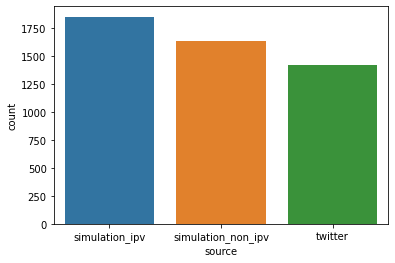

In [259]:
sns.countplot(df.source)
plt.savefig('source.png')
plt.show()

### Count aspect categories.

In [260]:
ac = df['ac'].dropna()
ac

0       [O, B-general_threat, I-general_threat, O, B-general_threat, O, O]                             
1       [B-character_assasination, I-character_assasination, I-character_assasination, O, O, O, O]     
2       [B-character_assasination, I-character_assasination, O, O, O, O, O, O, O, O, O, B-profanity, O]
3       [O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]                                  
4       [O, B-profanity, I-profanity, O, B-profanity, I-profanity, O]                                  
                                    ...                                                                
3483    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]                                                  
3484    [O, O, O, O, O, O, O, O, O, O, B-profanity, O, O]                                              
3485    [O, B-profanity, I-profanity, O, O]                                                            
3486    [O, O, O, O, O, O]                                      

In [277]:
from collections import Counter
temp = ac.sum()
temp = [ff[2:] for ff in temp if temp != "O"]

counts = Counter(temp)
counts

Counter({'': 30662,
         'general_threat': 1998,
         'character_assasination': 2207,
         'profanity': 5636,
         'physical_threat': 1817,
         'rape_threat': 109,
         'sexism': 201,
         'ethnic_violence': 186,
         'Others': 36,
         'religion_violence': 81})

In [282]:
x = pd.DataFrame(counts, index = range(len(counts)))
x = x.iloc[0, :].T
x

                          30662
general_threat            1998 
character_assasination    2207 
profanity                 5636 
physical_threat           1817 
rape_threat               109  
sexism                    201  
ethnic_violence           186  
Others                    36   
religion_violence         81   
Name: 0, dtype: int64

In [294]:
x = x.nlargest(9)

In [295]:
x.to_excel('ac.xlsx')